In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy.signal
import requests
import PIL.Image
import io

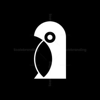

In [3]:
# png of neco arc
url = 'https://scalebranding.com/wp-content/uploads/2022/02/Simple-Penguin-Logo-2-300x300.jpg'
#url = 'https://us-tuna-sounds-images.voicemod.net/3736869e-87ba-40ab-925e-fbe36d5446bf-1695597335640.png'
response = requests.get(url)
img = PIL.Image.open(io.BytesIO(response.content))  
# convert to grayscale 100x100
img = img.resize((100,100)).convert('L')
img

In [4]:
p_event = np.zeros((100, 100), dtype=np.float32)
# smily face
p_event[10:20, 10:20] = 1
p_event[10:20, 80:90] = 1
p_event[80:90, 10:20] = 1
#p_event[80:90, 80:90] = 1
p_event[30:70, 30:70] = 1
p_event[40:70, 40:70] = 0


# blur it
p_event = scipy.signal.convolve2d(p_event, np.ones((10, 10)), mode='same')#
#p_event = np.asarray(img)[::-1]
# normalize
p_event = p_event / p_event.sum()

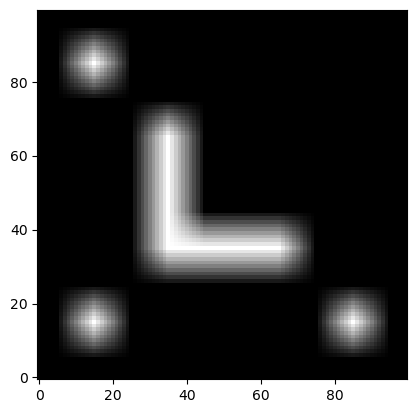

In [5]:
imshow(p_event, cmap='gray', origin='lower')

In [6]:
cdf = p_event.ravel().cumsum()

In [7]:
num_events = 10000
events = []
for i in range(num_events):
    r = np.random.rand()
    idx = np.searchsorted(cdf, r).clip(1,None) - 1
    i, j = np.unravel_index(idx, p_event.shape)
    # if i,j outside of radius 1, try again
    if (i-50)**2 + (j-50)**2 < 50**2:
        events.append((i, j))
        #scatter(j, i, color='r', marker='.', s=1)
#xlim(0, 100)
#ylim(0, 100)

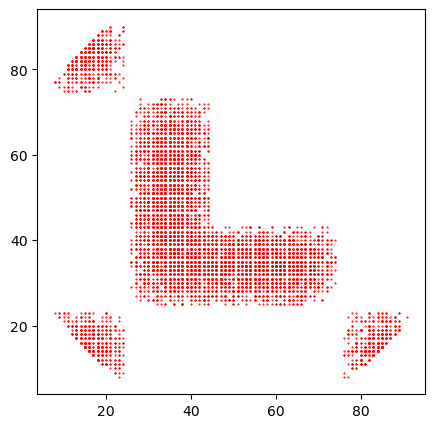

In [8]:
figure(figsize=(5,5))
scatter(*zip(*events), color='r', marker='.', s=1)

In [9]:
n_detectors = 360
detector_angles = np.linspace(-np.pi, np.pi, n_detectors, endpoint=False)

In [10]:
def detect_event(i,j):
    random_detector = np.random.randint(0, n_detectors)
    x = (j - 50) / 50
    y = (i - 50) / 50
    det_x = np.cos(detector_angles[random_detector])
    det_y = np.sin(detector_angles[random_detector])
    dx = x - det_x
    dy = y - det_y
    angle = np.arctan2(dy, dx)
    other_det_x = np.cos(detector_angles) - det_x
    other_det_y = np.sin(detector_angles) - det_y
    other_angles = np.arctan2(other_det_y, other_det_x)
    other_angles[random_detector] = 10000
    det2 = abs(other_angles - angle).argmin()
    det2_x = np.cos(detector_angles[det2])
    det2_y = np.sin(detector_angles[det2])

    #these calculations are for determining the annihilation point on the detector line
    det_coord = np.array([det_x, det_y])
    det2_coord = np.array([det2_x, det2_y])
    det_vec = det_coord - det2_coord
    det_vec_norm = det_vec / np.linalg.norm(det_vec)
    point_coord = np.array([x,y]) - det2_coord
    proj_point = point_coord.dot(det_vec_norm)*det_vec_norm + det2_coord
    # compute distances to detectors
    tof_det = np.linalg.norm(proj_point - det_coord)
    tof_other_det = np.linalg.norm(proj_point - det2_coord)
    delta_tof = tof_det - tof_other_det

    return random_detector, det2, delta_tof

In [11]:
detections = [detect_event(i,j) for i,j in events]

(array([  21.,   22.,  404., 1209., 1244., 1704., 2248.,  802.,  306.,
         481.]),
 array([-1.89815952, -1.50907187, -1.11998421, -0.73089656, -0.34180891,
         0.04727874,  0.4363664 ,  0.82545405,  1.2145417 ,  1.60362935,
         1.99271701]),
 <BarContainer object of 10 artists>)

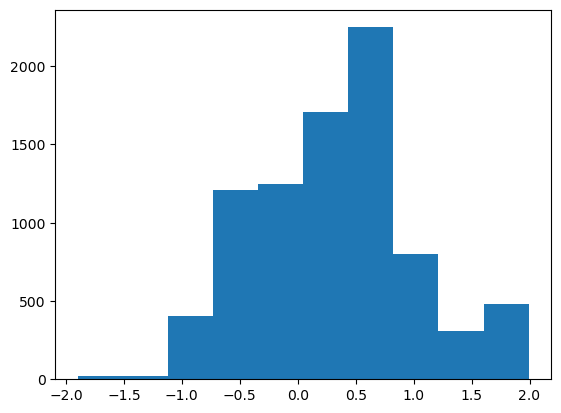

In [12]:
hist([d[-1] for d in detections])

# Export to CSV

In [13]:
with open('pet_det_events.csv', 'w') as f:
    f.write('det1_x,det1_y,det2_x,det2_y,delta_tof\n')
    for det1, det2, delta_tof in detections:
        det1_x = np.cos(detector_angles[det1])
        det1_y = np.sin(detector_angles[det1])
        det2_x = np.cos(detector_angles[det2])
        det2_y = np.sin(detector_angles[det2])
        f.write(f'{det1_x:.3f},{det1_y:.3f},{det2_x:.3f},{det2_y:.3f},{delta_tof:.3f}\n')

# Time of Flight

In [14]:
def plot_detection(det1, det2, alpha=.01, **kwargs):
    det1_x = np.cos(detector_angles[det1])
    det1_y = np.sin(detector_angles[det1])
    det2_x = np.cos(detector_angles[det2])
    det2_y = np.sin(detector_angles[det2])
    plot([det1_x, det2_x], [det1_y, det2_y], 'k', alpha=alpha, **kwargs)
    xlim(-1, 1)
    ylim(-1, 1)